## Задание № 5

### Урок 5. Случайный лес

#### Задание

1. Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.
2. **(*)** Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

### Реализация дерева решений


Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [192]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [193]:
random.seed(42)


def get_bootstrap(data, labels, N, is_verbose = False):
    n_samples = data.shape[0]
    bootstrap = []
    # множество всех примеров
    samples_idx = set(range(n_samples))
    # для вершины - примеры кот не участвуют в обуч
    oob_reestr = dict()

    # по каждому дереву
    for i in range(N):
        # примеры которые участвуют в обучении
        mark = []
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        # по каждому примеру
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples - 1)
            mark.append(int(sample_index))
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        # для каждого дерева фиксируем примеры которые не участвуют в обучении.
        oob_reestr[i] = sorted(samples_idx - set(mark))
        bootstrap.append((b_data, b_labels))
    if is_verbose:
        print(oob_reestr)
    return bootstrap

In [194]:
# my_forest = random_forest(train_data, train_labels, 2)

In [195]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]

    len_subsample = int(np.sqrt(len_sample))
    subsample = []

    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())

    return subsample

Далее повторим реализацию построения дерева решений из предыдущего урока с некоторыми изменениями

In [196]:
# Реализуем класс узла

class Node:

    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [197]:
# И класс терминального узла (листа)

class Leaf:

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()

    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его
        prediction = max(classes, key=classes.get)
        return prediction

In [198]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1

    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2

    return impurity

In [199]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):
    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])

    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [200]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)

    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]

    return true_data, false_data, true_labels, false_labels

In [201]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]

    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)

    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])

        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue

            current_quality = quality(true_labels, false_labels, current_gini)

            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [202]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):
    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Теперь добавим функцию формирования случайного леса.

In [203]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)

    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))

    return forest

In [204]:
# Функция классификации отдельного объекта

def classify_object(obj, node):
    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [205]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [206]:
# предсказание голосованием деревьев

def tree_vote(forest, data):
    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))

    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))

    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))

    return voted_predictions

In [207]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

### Задача 1
Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

In [208]:
from sklearn import model_selection


In [209]:

classification_data, classification_labels = datasets.make_classification(
    n_samples=1000,
    n_features=2,
    n_informative=2,
    n_classes=2,
    n_redundant=0,
    n_clusters_per_class=1,
    flip_y=0.1,
    random_state=42)

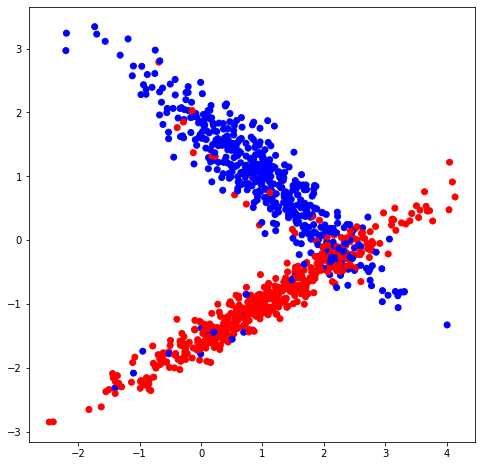

In [210]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8, 8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)),
            c=classification_labels, cmap=colors)

# Разобьем выборку на обучающую и тестовую

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data,
                                                                                    classification_labels,
                                                                                    test_size=0.3,
                                                                                    random_state=1)

In [211]:
def show_ds(train_data, train_labels, test_data, test_labels, my_forest):
    def get_meshgrid(data, step=.05, border=1.2):
        x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
        y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
        return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

    plt.figure(figsize=(16, 7))

    # train_answers = predict(train_data, my_tree)
    train_answers = tree_vote(my_forest, train_data)

    # И получим ответы для тестовой выборки
    answers = tree_vote(my_forest, test_data)

    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(train_labels, train_answers)
    # Точность на тестовой выборке
    test_accuracy = accuracy_metric(test_labels, answers)
    # график обучающей выборки
    plt.subplot(1, 2, 1)
    xx, yy = get_meshgrid(train_data)

    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors, shading='auto')
    plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, cmap=colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1, 2, 2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap=light_colors, shading='auto')
    plt.scatter(test_data[:, 0], test_data[:, 1], c=test_labels, cmap=colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

Случайный лес из 1 деревьев
	 Точность на обучающей выборке: 	95.571
	 Точность на тестовой выборке: 		86.667
Случайный лес из 3 деревьев
	 Точность на обучающей выборке: 	96.571
	 Точность на тестовой выборке: 		88.000
Случайный лес из 10 деревьев
	 Точность на обучающей выборке: 	99.143
	 Точность на тестовой выборке: 		89.667
Случайный лес из 50 деревьев
	 Точность на обучающей выборке: 	99.571
	 Точность на тестовой выборке: 		90.000
Случайный лес из 100 деревьев
	 Точность на обучающей выборке: 	100.000
	 Точность на тестовой выборке: 		90.000
Случайный лес из 200 деревьев
	 Точность на обучающей выборке: 	100.000
	 Точность на тестовой выборке: 		90.333


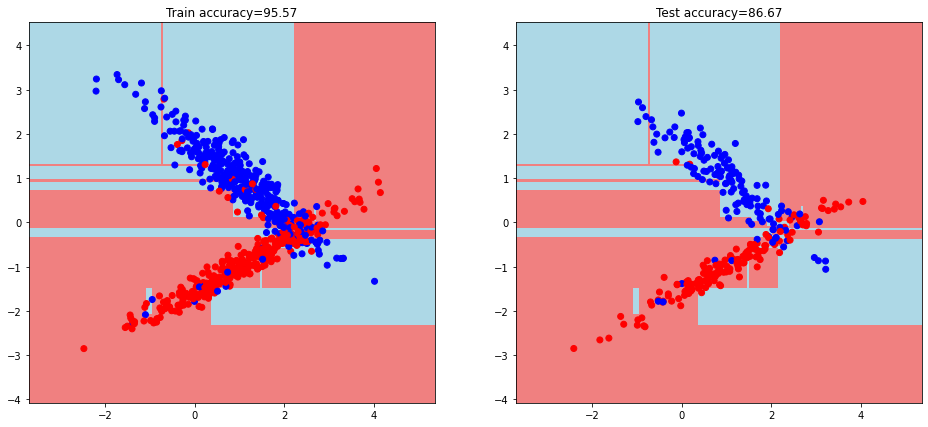

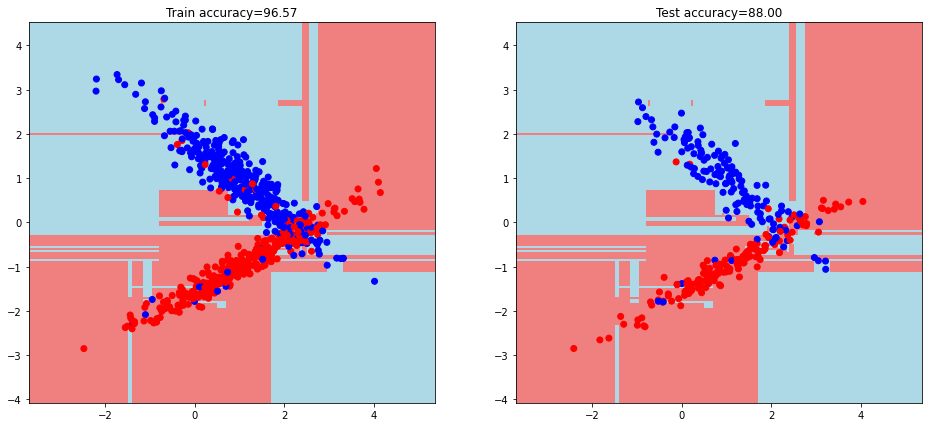

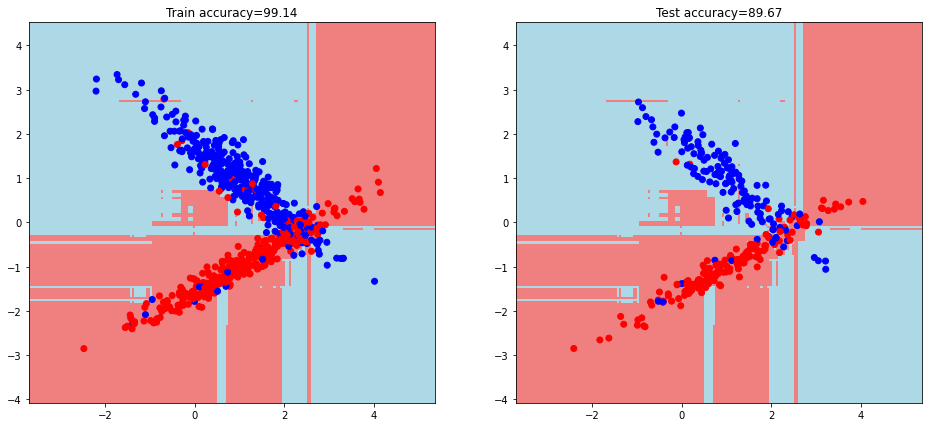

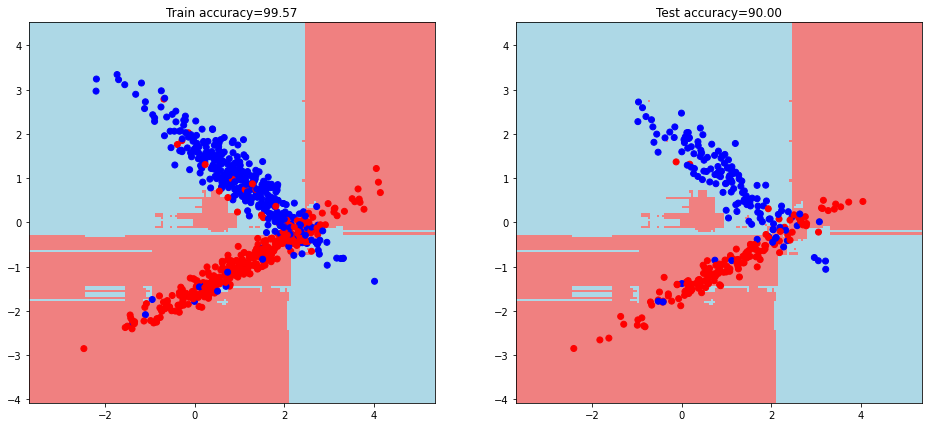

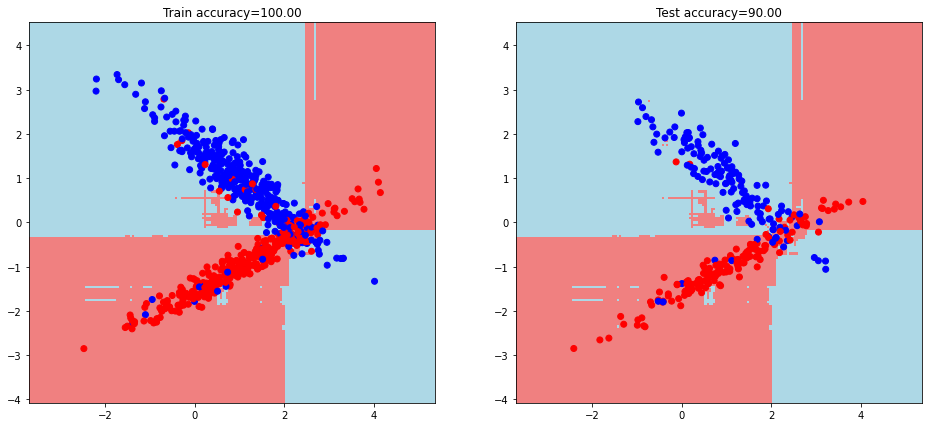

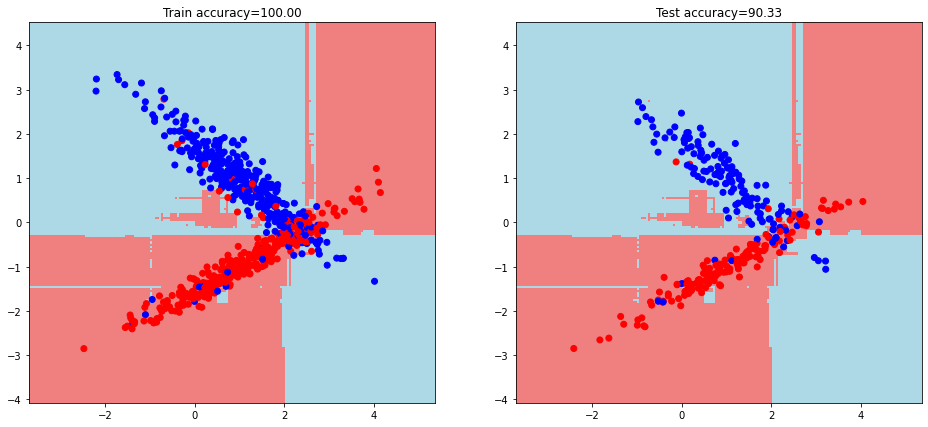

In [212]:
for n_trees in [1, 3, 10, 50, 100, 200]:
    print(f'Случайный лес из {n_trees} деревьев')
    my_forest = random_forest(train_data, train_labels, n_trees)
    # Получим ответы для обучающей выборки
    train_answers = tree_vote(my_forest, train_data)
    # И получим ответы для тестовой выборки
    test_answers = tree_vote(my_forest, test_data)
    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(train_labels, train_answers)
    print(f'\t Точность на обучающей выборке: \t{train_accuracy:.3f}')
    # Точность на тестовой выборке
    test_accuracy = accuracy_metric(test_labels, test_answers)
    print(f'\t Точность на тестовой выборке: \t\t{test_accuracy:.3f}')
    show_ds(train_data, train_labels, test_data, test_labels, my_forest)


> Разница в качестве на выборке обучения по сравнению с тестовой выборкой не превышает 10%. Это приемлемый результат.
> Модель хорошо воспринимает закономерности в данных.
> При этом при существенном возрастании количества деревьев с 3 до 200 (на два порядка), качество выросло незначительно с 86% до 90%
> Этот результат показан на небольшом количестве признаков (2), возможно для большого количества измерений
> необходимость большого количества деревьев будет обоснованной.
>

### Задача 2
**(*)** Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.


> Реализован реестр для хранения примеров которые не участвовали в обучении для данной вершине.
>

In [213]:
_=get_bootstrap(train_data, train_labels, 10, is_verbose=True )

{0: [0, 5, 8, 15, 19, 22, 25, 28, 29, 30, 32, 34, 41, 42, 45, 48, 50, 51, 59, 65, 71, 72, 75, 78, 87, 90, 96, 99, 100, 101, 102, 106, 108, 109, 113, 114, 119, 122, 127, 128, 130, 131, 133, 137, 141, 144, 147, 149, 150, 152, 154, 155, 156, 157, 159, 162, 163, 167, 168, 173, 177, 181, 184, 187, 189, 193, 196, 197, 199, 200, 201, 204, 205, 206, 210, 217, 221, 223, 227, 231, 233, 237, 238, 240, 241, 247, 250, 251, 252, 255, 257, 259, 266, 275, 280, 282, 284, 285, 295, 296, 297, 299, 307, 308, 309, 310, 316, 317, 318, 323, 325, 328, 329, 338, 340, 341, 342, 344, 346, 349, 350, 355, 360, 361, 362, 364, 366, 368, 371, 373, 376, 381, 384, 387, 396, 403, 405, 408, 410, 412, 413, 414, 415, 416, 419, 425, 426, 433, 434, 436, 439, 444, 446, 447, 448, 449, 453, 456, 459, 460, 461, 466, 469, 473, 474, 480, 481, 482, 484, 486, 487, 491, 493, 494, 497, 498, 499, 500, 501, 504, 507, 509, 510, 513, 517, 518, 523, 524, 526, 527, 530, 531, 532, 542, 545, 546, 547, 548, 549, 551, 554, 555, 560, 562, 568, 5

> Реализовать преобразование реестра от примера до дерева.

